In [1]:
import cinrad
import pyart



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/liyuan3970/anaconda3/lib/python3.7/site-packages/h5py/_hl/base.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (Mapping, MutableMapping, KeysView,
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/h5py/_hl/base.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (Mapping, MutableMapping, KeysView,
/home/liyuan3970/anaconda3/lib/python3.7/site-packages/h5py/_hl/base.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (Mapping, MutableMapping, KeysView,


In [6]:
# coding = utf-8
# Author: Puyuan Du

from typing import Callable
from functools import wraps

import numpy as np

from cinrad.io.level2 import StandardData

try:
    import pyart

    PYART_INSTALLED = True
except ImportError:
    PYART_INSTALLED = False


def check_pyart_installed(func: Callable) -> Callable:
    @wraps(func)
    def deco(*args, **kwargs):
        if not PYART_INSTALLED:
            raise ImportError("pyart is not installed")
        return func(*args, **kwargs)

    return deco


mapping = {
    "REF": "reflectivity",
    "VEL": "velocity",
    "SW": "spectrum_width",
    "PHI": "differential_phase",
    "ZDR": "differential_reflectivity",
    "RHO": "cross_correlation_ratio",
}


@check_pyart_installed
def standard_data_to_pyart(f: StandardData, radius: int = 460) -> pyart.core.Radar:
    filemetadata = pyart.config.FileMetadata("cinrad standard")
    time = filemetadata("time")
    time["calendar"] = "standard"
    time["units"] = "seconds since 1970-01-01 00:00"
    time["standard_name"] = "time"
    time["long_name"] = "time in seconds since volume start"
    time["data"] = f._time_radial

    _range = filemetadata("range")
    reso = f.scan_config[0].dop_reso
    _range["data"] = np.arange(reso, radius * 1000 + reso, reso, "float32")
    _range["meters_to_center_of_first_gate"] = float(reso)
    _range["meters_between_gates"] = float(reso)

    metadata = filemetadata("metadata")
    metadata["original_container"] = "CINRAD"
    vcp_pattern = f.scan_type
    metadata["instrument_name"] = f.code

    scan_type = "ppi"

    latitude = filemetadata("latitude")
    longitude = filemetadata("longitude")
    altitude = filemetadata("altitude")

    latitude["data"] = np.array([f.stationlat], dtype="float64")
    longitude["data"] = np.array([f.stationlon], dtype="float64")
    altitude["data"] = np.array([f.radarheight], dtype="float64")

    sweep_number = filemetadata("sweep_number")
    sweep_mode = filemetadata("sweep_mode")
    sweep_start_ray_index = filemetadata("sweep_start_ray_index")
    sweep_end_ray_index = filemetadata("sweep_end_ray_index")

    nsweeps = len(f.el)
    sweep_number["data"] = np.arange(nsweeps, dtype="int32")
    sweep_mode["data"] = np.array(nsweeps * ["azimuth_surveillance"], dtype="S")

    sweep_end_ray_index["data"] = np.array(f._sweep_end_ray_index)
    sweep_start_ray_index["data"] = np.array(f._sweep_start_ray_index)

    azimuth = filemetadata("azimuth")
    elevation = filemetadata("elevation")
    fixed_angle = filemetadata("fixed_angle")
    azimuth["data"] = np.hstack([f.aux[i]["azimuth"] for i in f.aux.keys()])
    elevation["data"] = np.hstack([f.aux[i]["elevation"] for i in f.aux.keys()])
    fixed_angle["data"] = np.array(f.el)

    fields = {}
    nscans = f.get_nscans()

    for mom in mapping.keys():
        name = mapping[mom]
        dic = filemetadata(name)
        dic["_FillValue"] = pyart.config.get_fillvalue()
        raw_arr = [f.get_raw(nel, radius, mom) for nel in range(nscans)]
        sel_arr = [i if not isinstance(i, tuple) else i[0] for i in raw_arr]
        moment_data = np.ma.vstack(sel_arr)
        dic["data"] = moment_data
        fields[name] = dic

    nyquist_velocity = filemetadata("nyquist_velocity")
    nyquist_velocity["data"] = np.array(
        [i.nyquist_spd for i in f.scan_config], "float32"
    )
    unambiguous_range = filemetadata("unambiguous_range")
    unambiguous_range["data"] = np.array(
        [i.max_range1 for i in f.scan_config], "float32"
    )

    instrument_parameters = {
        "unambiguous_range": unambiguous_range,
        "nyquist_velocity": nyquist_velocity,
    }

    radar = pyart.core.Radar(
        time,
        _range,
        fields,
        metadata,
        scan_type,
        latitude,
        longitude,
        altitude,
        sweep_number,
        sweep_mode,
        fixed_angle,
        sweep_start_ray_index,
        sweep_end_ray_index,
        azimuth,
        elevation,
        instrument_parameters=instrument_parameters,
    )
    return radar


In [2]:
f = cinrad.io.CinradReader('Z_RADR_I_Z9576_20190810000600_O_DOR_SA_CAP.bin.bz2')

In [11]:
from pycwr.io.auto_io import radar_io 
import numpy as np
import pandas as pd
import xarray as xr
f = r"Z_RADR_I_Z9576_20190810000600_O_DOR_SA_CAP.bin.bz2"
r = radar_io(f) 
radar = r.ToPyartRadar()
print(radar)
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width'])


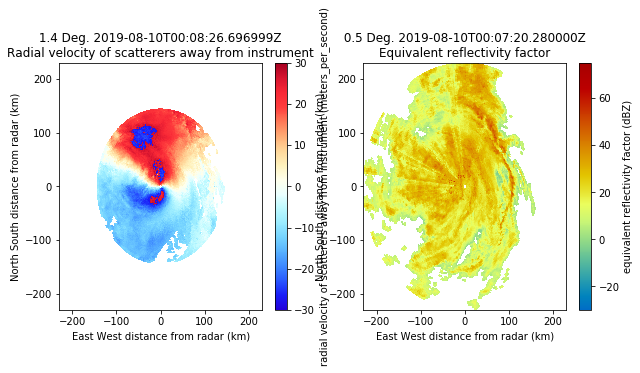

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(221)
display.plot('velocity', 1, ax=ax)
#display.set_limits((-300, 300), (-300, 300), ax=ax)

ax = fig.add_subplot(222)
display.plot('reflectivity', 0, ax=ax)
#display.set_limits((-300, 300), (-300, 300), ax=ax)


plt.show()